In [525]:
#import train data using pandas
#key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count

import pandas as pd
import numpy as np
from pyproj import Geod
from scipy import stats
import seaborn
import matplotlib.pyplot as plt
import math
from math import sqrt
from scipy.stats import zscore
from sklearn import preprocessing
import os
import csv

taxi_train_df = pd.read_csv('train-small.csv',  error_bad_lines=False, usecols=range(1,8))
print("Loaded %d rows" % len(taxi_train_df))

Loaded 2500 rows


In [526]:
#clean the data



num_cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
int_cols = ['passenger_count']
date_cols = ['pickup_datetime']

#filter out rows where numerical values are not numerical
taxi_train_df[num_cols] = taxi_train_df[num_cols].apply(pd.to_numeric, errors='coerce').astype(np.float32)

#filter out invalid dates
taxi_train_df[date_cols] = taxi_train_df[date_cols].apply(pd.to_datetime, errors='coerce')

#filter out latitides==0 or longitudes=0
taxi_train_df.loc[taxi_train_df['pickup_longitude']==0, 'pickup_longitude'] = np.nan
taxi_train_df.loc[taxi_train_df['pickup_latitude']==0, 'pickup_latitude'] = np.nan
taxi_train_df.loc[taxi_train_df['dropoff_longitude']==0, 'dropoff_longitude'] = np.nan
taxi_train_df.loc[taxi_train_df['dropoff_latitude']==0, 'dropoff_latitude'] = np.nan
taxi_train_df.loc[taxi_train_df['passenger_count']>6, 'passenger_count'] = np.nan
taxi_train_df.loc[taxi_train_df['fare_amount']==0, 'passenger_count'] = np.nan


#drop NaN values
taxi_train_df = taxi_train_df.dropna()

#taxi_train_df.pickup_longitude = taxi_train_df.pickup_longitude.round(3)
#taxi_train_df['pickup_latitude'] = taxi_train_df['pickup_latitude'].round(6)
'''taxi_train_df.style.format({
    'pickup_longitude': '{:,.1f}'.format,
    'dropoff_longitude': '{:,.3f}'.format,
})'''

print(taxi_train_df.dtypes)

#filter out rows where pick_lat==drop_lat and pick_long==drop_lat
#taxi_train_df = [row for index,row in taxi_train_df.iterrows() if row['pickup_latitude'] != row['dropoff_latitude'] or row['pickup_longitude'] != row['dropoff_longitude'] or row['pickup_latitude']==0 or row['dropoff_latitude'] == 0 or row['pickup_longitude']==0 or row['dropoff_longitude']==0]



print(len(taxi_train_df))
print(taxi_train_df.values[0])


fare_amount                 float32
pickup_datetime      datetime64[ns]
pickup_longitude            float32
pickup_latitude             float32
dropoff_longitude           float32
dropoff_latitude            float32
passenger_count             float32
dtype: object
2449
[4.5 Timestamp('2009-06-15 17:26:21') -73.84431457519531
 40.721317291259766 -73.84161376953125 40.712276458740234 1.0]


In [527]:
wgs84_geod = Geod(ellps='WGS84')

#get euclidean distance between 2 lat long points
def get_euclidean_distance(row):
  az12,az21,dist = wgs84_geod.inv(row['pickup_longitude'],row['pickup_latitude'],row['dropoff_longitude'],row['dropoff_latitude'])
  return dist

#get manhattan distance between 2 lat long points
def get_manhattan_distance(row):
    y = abs(row['pickup_longitude']-row['dropoff_longitude']) 
    x = abs(row['pickup_latitude']-row['dropoff_latitude'])
    if(x==0 or y==0):
        return row['euclidean_dist'] 
    z=y/x;
    x = row['euclidean_dist']/sqrt(1+(z*z))
    return x+z*x
    

#get hour and minute distance between 2 lat long points
def get_hour_minute(row):
    return int(row['pickup_datetime'].hour)*100 + int(row['pickup_datetime'].minute)

def get_date_month(row):
    return int(row['pickup_datetime'].month)*100 + int(row['pickup_datetime'].day)

def get_fare_per_km(row):
     return (row['fare_amount']*1000)/row['manhattan_dist']

def get_year_month(row):
    return int(row['pickup_datetime'].year)*100 + int(row['pickup_datetime'].month)

def get_time_slot(row):
    return int(row['time_of_day']/100)

def get_day_of_week(row):
    return row['pickup_datetime'].weekday()

def add_set1_features(taxi_train_df):
    taxi_train_df['euclidean_dist'] = taxi_train_df.apply (lambda row: get_euclidean_distance(row),axis=1)
    taxi_train_df['manhattan_dist'] = taxi_train_df.apply (lambda row: get_manhattan_distance(row),axis=1)
    taxi_train_df['time_of_day'] = taxi_train_df.apply (lambda row: get_hour_minute(row),axis=1)
    taxi_train_df['day_of_year'] = taxi_train_df.apply (lambda row: get_date_month(row),axis=1)

def add_set2_features(taxi_train_df):
    taxi_train_df['month_of_year'] = taxi_train_df.apply (lambda row: get_year_month(row),axis=1)
    taxi_train_df['time_slot'] = taxi_train_df.apply (lambda row: get_time_slot(row),axis=1)
    taxi_train_df['day_of_week'] = taxi_train_df.apply (lambda row: get_day_of_week(row),axis=1)
    print(taxi_train_df.values[0])
    
add_set1_features(taxi_train_df) 

taxi_train_df.loc[taxi_train_df['euclidean_dist']==0, 'euclidean_dist'] = np.nan
taxi_train_df = taxi_train_df.dropna()

taxi_train_df['fare_per_km'] = taxi_train_df.apply (lambda row: get_fare_per_km(row),axis=1)
add_set2_features(taxi_train_df)

taxi_train_df.loc[taxi_train_df['fare_per_km']>30, 'fare_per_km'] = np.nan
taxi_train_df.loc[taxi_train_df['fare_per_km']<0.3, 'fare_per_km'] = np.nan
taxi_train_df = taxi_train_df.dropna()


[4.5 Timestamp('2009-06-15 17:26:21') -73.84431457519531
 40.721317291259766 -73.84161376953125 40.712276458740234 1.0
 1029.578969039803 1281.202333908878 1726 615 3.5123257903150606 200906 17
 0]


In [528]:
#2.1
print("Pearson correlation between fare amount and euclidean distance: %f" % stats.pearsonr(taxi_train_df.fare_amount, taxi_train_df.euclidean_dist)[0])

#2.2
print("Pearson correlation between time of day and distance travelled: %f" % stats.pearsonr(taxi_train_df.time_of_day, taxi_train_df.manhattan_dist)[0])

#2.3
print("Pearson correlation between fare amount and manhattan distance: %f" % stats.pearsonr(taxi_train_df.time_of_day, taxi_train_df.fare_amount)[0])


Pearson correlation between fare amount and euclidean distance: 0.908813
Pearson correlation between time of day and distance travelled: -0.040581
Pearson correlation between fare amount and manhattan distance: -0.043236


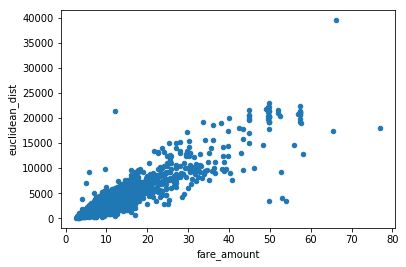

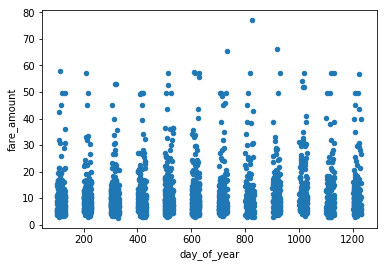

In [529]:
#3.1.1 Plot between taxi fare and distance travelled
plot = taxi_train_df.plot.scatter('fare_amount', 'euclidean_dist')
plot = taxi_train_df.plot.scatter('day_of_year', 'fare_amount')

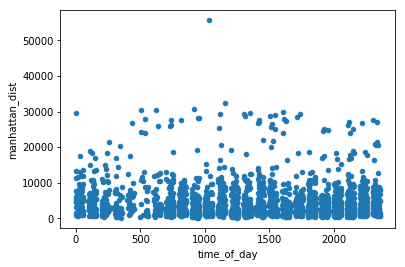

In [530]:
#3.2.1 Plot between time of day and distance travelled
plot = taxi_train_df.plot.scatter('time_of_day', 'manhattan_dist')


In [531]:
from numpy import linalg as LA
a = np.array((taxi_train_df['pickup_latitude'],taxi_train_df['pickup_longitude']))
b = np.array((taxi_train_df['dropoff_latitude'],taxi_train_df['dropoff_longitude']))
dist = np.linalg.norm(a-b)
print(dist)


2.5440922


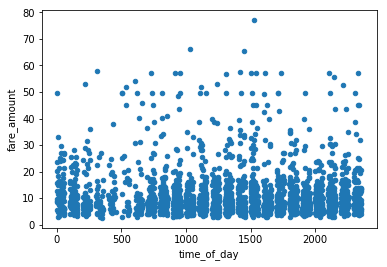

In [532]:
#3.3.1 Plot between time of day and distance travelled
plot = taxi_train_df.plot.scatter('time_of_day', 'fare_amount')

In [533]:
taxi_train_df.groupby('time_slot')['fare_per_km'].aggregate('mean')



time_slot
0     3.087096
1     2.982901
2     3.212037
3     4.535620
4     2.665567
5     3.163059
6     2.963691
7     3.245867
8     3.315050
9     4.166777
10    3.538896
11    3.478964
12    4.500660
13    3.665725
14    3.681096
15    3.488508
16    3.792645
17    3.631565
18    3.563083
19    3.374879
20    3.123666
21    3.291239
22    3.187786
23    3.014360
Name: fare_per_km, dtype: float64

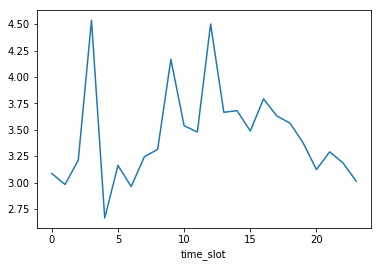

In [534]:
taxi_train_df.groupby('time_slot')['fare_per_km'].aggregate('mean').plot()

In [535]:


#taxi_train_df[(taxi_train_df["time_slot"] >7) & (taxi_train_df["time_slot"] < 13)].groupby('day_of_week')['fare_per_km'].aggregate('mean')

#taxi_train_df[(taxi_train_df["time_slot"] >14) & (taxi_train_df["time_slot"] < 20)].groupby('day_of_week')['fare_per_km'].aggregate('mean').plot().bar()
#plt.show()

In [536]:
taxi_train_df[(taxi_train_df["time_slot"] >14) & (taxi_train_df["time_slot"] < 20)].groupby('day_of_week')['fare_per_km'].aggregate('mean')


day_of_week
0    3.360338
1    4.168187
2    3.646721
3    3.610615
4    3.454685
5    3.417689
6    3.247160
Name: fare_per_km, dtype: float64

In [537]:
#taxi_train_df.day_of_week = pd.Categorical(pd.factorize(taxi_train_df.day_of_week)[0])



#taxi_train_df.manhattan_dist = taxi_train_df.manhattan_dist/taxi_train_df.manhattan_dist.max()
#taxi_train_df.time_slot = taxi_train_df.time_slot/taxi_train_df.time_slot.max()

#taxi_train_df.day_of_week = taxi_train_df.day_of_week/taxi_train_df.day_of_week.max()

def get_input_matrix(taxi_train_df):
    return np.column_stack((taxi_train_df.manhattan_dist, taxi_train_df.time_slot, taxi_train_df.day_of_week))

features_cols = get_input_matrix(taxi_train_df)
predict_cols =  np.array(taxi_train_df['fare_amount'])
            
print(features_cols.shape)
print(predict_cols.shape)


(2398, 3)
(2398,)


In [538]:
(w, _, _, _) = np.linalg.lstsq(features_cols, predict_cols, rcond = None)
print(w)

[0.00176028 0.14479452 0.36777884]


In [539]:
test_data_df = pd.read_csv('test.csv')


test_data_df[date_cols] = test_data_df[date_cols].apply(pd.to_datetime, errors='coerce')

add_set1_features(test_data_df)
add_set2_features(test_data_df)

test_X = get_input_matrix(test_data_df)
test_y_predictions = np.matmul(test_X, w).round(decimals = 2)

submission = pd.DataFrame(
    {'key': test_data_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission.csv', index = False)


print("wrote csv file in submission.csv")



['2015-01-27 13:08:24.0000002' Timestamp('2015-01-27 13:08:24')
 -73.97332000732422 40.7638053894043 -73.98143005371094 40.74383544921875
 1 2320.9910982709694 3023.7379634765907 1308 127 201501 13 1]
wrote csv file in submission.csv


In [540]:

def get_inflation_data(file):
    with open(file, mode='r') as f:
        reader = csv.reader(f)
        return {rows[0]:rows[1] for rows in reader}

cpi_inflation = get_inflation_data('inflation-data.csv')

def get_inflation_adjusted_price(row):
    return row['fare_amount']*float(mydict['201808'])/mydict[]
    
taxi_train_df['inflation_adjusted_fare'] = taxi_train_df.apply (lambda row: get_manhattan_distance(row),axis=1)


{'month_of_year': 'inflation', '200801': '211.080', '200802': '211.693', '200803': '213.528', '200804': '214.823', '200805': '216.632', '200806': '218.815', '200807': '219.964', '200808': '219.086', '200809': '218.783', '200810': '216.573', '200811': '212.425', '200812': '210.228', '200901': '211.143', '200902': '212.193', '200903': '212.709', '200904': '213.240', '200905': '213.856', '200906': '215.693', '200907': '215.351', '200908': '215.834', '200909': '215.969', '200910': '216.177', '200911': '216.330', '200912': '215.949', '201001': '216.687', '201002': '216.741', '201003': '217.631', '201004': '218.009', '201005': '218.178', '201006': '217.965', '201007': '218.011', '201008': '218.312', '201009': '218.439', '201010': '218.711', '201011': '218.803', '201012': '219.179', '201101': '220.223', '201102': '221.309', '201103': '223.467', '201104': '224.906', '201105': '225.964', '201106': '225.722', '201107': '225.922', '201108': '226.545', '201109': '226.889', '201110': '226.421', '20